In [3]:
# Imports not from the google drive
# stdlib
import copy
import math
import os
import random
import sys

# external
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!pip install import_ipynb
# external
import import_ipynb

# Imports from the google drive
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions
file_dir = "/content/drive/Shared drives/Space Systems Divison/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions"
sys.path.append(os.path.abspath(file_dir))
# external
import apply_stripes

%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models
file_dir = "/content/drive/Shared drives/Space Systems Divison/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models"
sys.path.append(os.path.abspath(file_dir))
# external
import noise_estimation

%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master
file_dir = "/content/drive/Shared drives/Space Systems Divison/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master"
sys.path.append(os.path.abspath(file_dir))
# external
from models.skipnet import *
from utils.common import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 
Mounted at /content/drive
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions
importing Jupyter notebook from apply_stripes.ipynb
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models
importing Jupyter notebook from noise_estimation.ipynb
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master


In [4]:
def import_indian_pines_data(to_import=True):
    """
    import Indian Pines dataset from Science Google Drive
    Args:
      import: if True import the dataset from Googel Drive, if false doesn't import
      To change the location of import to github

    Return: print statement of whether the dataset is imported properly or not
    """
    if to_import == True:
        # data get data to add stripe
        #!git clone https://github.com/spacesys-finch/Science #if says error uncomment this line
        # error cloning, so uploaded the data to google drive instead
        data = np.load(
            "/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Datasets/indian_pine_array.npy"
        )

        # changing from callibrated value to radiance
        # radiance_data_np = (data-1000)/500
        radiance_data_np = data.astype(np.float32)
        return radiance_data_np

In [5]:
# write a function for nomalizing the values in the numpy array


def normalize(numpy_arr_one, numpy_arr_two):
    """
    Normalize the values in numpy_arr_one and numpy_arr_two into values between -1 and 1
    Args:
      numpy_arr_one, numpy_arr_two: numpy arrays of the data to normalize
    Return: numpy_arr_one_norm, numpy_arr_two_norm: two arrays that are normalized
    """

    max_num = max(np.max(numpy_arr_one), np.max(numpy_arr_two))
    divisor = np.ones(numpy_arr_one.shape) * max_num
    numpy_arr_one_norm = np.divide(numpy_arr_one, divisor)
    numpy_arr_two_norm = np.divide(numpy_arr_two, divisor)
    return numpy_arr_one_norm, numpy_arr_two_norm, max_num

In [6]:
def band_by_band_normalize(numpy_array):
    """
    Normalize the values in numpy_array band by band to between 0 and 1
    Args:
      numpy_array: 3D array of hyperspectral image
    Return:
      numpy_array_norm: normalized numpy array
    """
    bands = numpy_array.shape[2]
    for i in range(bands):
        max_num = np.max(numpy_array[:, :, i])
        numpy_array[:, :, i] = np.divide(numpy_array[:, :, i], max_num)
    return numpy_array

In [7]:
# reshape data to (1, data.shape[0], data.shape[1], data.shape[2])
def reshape(data):
    """
    Input: 3D Numpy array, Output: Reshaped 4D Numpy array
    Reshape HSI data from 3D to 4D to pass into CNN
    Ex. original data shape (20, 30, 40) will turn into (1, 20, 30, 40)
    """
    data_reshaped = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])
    return data_reshaped

In [8]:
def define_model(striped_data):
    """
    Define the models and the necessary parameters of the model

    Args: None
    Return:
      mymodel: model of the defined properties
      lr: alpha value
      myoptimizer: optimizer of choice
      loss_object: type of loss object
    """
    # Define model
    mymodel = skip(ndown=5, channel=striped_data.shape[-1])
    lr = 0.001
    myoptimizer = tf.keras.optimizers.Adam(lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    return mymodel, lr, myoptimizer, loss_object

In [9]:
# Calculate gradient
@tf.function
def grad(model, inputs, targets):
    sure = True
    with tf.GradientTape() as tape:
        loss_value, div_value = losshyper(
            model, inputs, targets, sigma=sigmaest, sure=sure
        )
    return loss_value, div_value, tape.gradient(loss_value, model.trainable_variables)

In [10]:
# function for calculating mean ssim (Structural Similarity Index)
def meanssim(X, Y):
    """
    Calculate the mean SSIM of the two images X and Y

    Args:
    x: first image to compare
    y: second image to compare with

    return
    np.mean(bandssim): mean similarity of the two images x and y
    """
    bandssim = []
    for i in range(X.shape[2]):
        bandssim.append(
            ssim(
                X[:, :, i],
                Y[:, :, i],
                data_range=1.0,
                K1=0.01,
                K2=0.03,
                gaussian_weights=True,
                sigma=1.5,
                use_sample_covariance=False,
            )
        )
    return np.mean(bandssim)

In [44]:
def train_model(train, model_file_path, striped_data, clean_data, num_epochs):
    """
    This function train the model and save the model

    Args:
      train: if true, train, if false not train
      model_file_path: filepath that the model is saved at
      striped_data: striped_data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])
      clean_data: clean data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      train_loss_results: list of the training loss
      destriped_psnr: list of the psnr between the

    """
    if train == True:
        mymodel, lr, myoptimizer, loss_object = define_model(striped_data)
        sure = True
        # start training
        train_loss_results = []
        train_div_results = []
        destriped_psnr = []
        destriped_ssim = []
        curr_psnr = 0
        sure = True
        # for loop for going through each epoch
        for epoch in range(num_epochs):
            loss_label = "SURE"
            # get gradient for the current model
            loss_value, div_value, grads = grad(mymodel, striped_data, striped_data)
            # apply gradient to the optimizer
            myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
            img_out = mymodel.predict(striped_data)
            # if the pnsr between the clean image and the output from the model is higher than the previous output, save the current model
            if psnr(clean_data[0], img_out[0]) > curr_psnr:
                print("Saving Model")
                tf.keras.models.save_model(mymodel, model_file_path)
                curr_psnr = psnr(clean_data[0], img_out[0])
            curr_ssim = meanssim(clean_data[0], img_out[0])

            print("This is running epoch %d and Loss %f" % (epoch, loss_value))
            print("PSNR: " + str(curr_psnr))
            print("SSIM: " + str(curr_ssim))
            print(
                "Iteration %05d    Loss %f     PSNR %f    SSIM: "
                % (epoch, loss_value, curr_psnr),
                "\r",
                end="",
            )
            # updating loss, div, ssim
            train_loss_results.append(loss_value)
            train_div_results.append(div_value)
            destriped_psnr.append(curr_psnr)
            destriped_ssim.append(curr_ssim)

        return train_loss_results, destriped_psnr, destriped_ssim

    else:
        print("Does not train")
        return [0], [0]

In [12]:
def load_model_and_predict(filepath, striped_data):
    """
    This function load the saved model from the filepath and apply the model to striped_data to get the output

    Args:
      filepath: filepath that the model is saved in, the model should be of type .hdf5
      striped_data: striped_data in the format of numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      bestmodel: the model that is loaded from the filepath
      out_best: the output from passing striped_data into the loaded model
    """
    # set the model to load the trained model
    bestmodel = tf.keras.models.load_model(filepath)
    # pass the noisy image into the model to get the output from the trained model
    out_best = bestmodel.predict(striped_data)
    return bestmodel, out_best

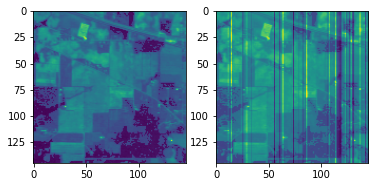

(200, 21025)   21025


In [13]:
# load data and add stripe/noise
ip_radiance_data_np = import_indian_pines_data()
ip_striped_data_np = ip_radiance_data_np
ip_radiance_data_np = band_by_band_normalize(ip_radiance_data_np)
ip_striped_data_np = band_by_band_normalize(ip_radiance_data_np)
num_stripes = []

num_bands = 200  # number of bands in the HSI

# add stripes, change to other type of noise
ip_striped_data_np = apply_stripes.add_basic_stripes(ip_radiance_data_np)

# plot the striped images
band = 12
plt.subplot(121)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(122)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.show()

# reshape radiance data and striped data
ip_radiance_data = reshape(ip_radiance_data_np)
ip_radiance_data = ip_radiance_data.astype(np.float32)
ip_striped_data = reshape(ip_striped_data_np)
ip_striped_data = ip_striped_data.astype(np.float32)

# calculate noise estimation
sigmaest = noise_estimation.noise_estimate(ip_radiance_data_np)
sigmaest = sigmaest.astype(np.float32)

In [50]:
# perform SVD
u, s, vh = np.linalg.svd(ip_striped_data, full_matrices=False)
print(ip_striped_data.shape)
print(u.shape, s.shape, vh.shape)
print(((u * s[..., None, :]) @ vh).shape)
print((u * s[..., None, :]).shape)
ip_striped_data = u * s[..., None, :]
# ip_striped_data = (u @ (s[..., None] * vh))

# clean image
u_clean, s_clean, vh_clean = np.linalg.svd(ip_radiance_data, full_matrices=False)
ip_radiance_data = u_clean * s[..., None, :]

(1, 145, 145, 145)
(1, 145, 145, 145) (1, 145, 145) (1, 145, 145, 145)
(1, 145, 145, 145)
(1, 145, 145, 145)


In [51]:
# change filename of the model saved
filepath = "./results/best model/Demo/" + "sure" + "indian_pine_SVD_US" + ".hdf5"

1/1 [==============================] - 2s 2s/step


Saving Model
This is running epoch 0 and Loss 0.257479
PSNR: 11.977643741849482
SSIM: -0.002104907046687841
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 1 and Loss 0.253051
PSNR: 12.289453471036358
SSIM: -0.0020100897631950897
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 2 and Loss 0.235455
PSNR: 14.118614838331517
SSIM: -0.0007888398892740539
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 3 and Loss 0.154129
PSNR: 15.075192218149807
SSIM: 0.051123640878611785
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 4 and Loss 0.123231
PSNR: 17.08732195416714
SSIM: 0.06408270597860896
1/1 [==============================] - 1s 1s/step
This is running epoch 5 and Loss 0.077106
PSNR: 17.08732195416714
SSIM: 0.06676861185194392
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 6 and Loss 0.081483
PSNR: 17.95315577018366
SSIM: 0.06925559854944424
1/1 [==============================] - 1s 1s/step
This is running epoch 7 and Loss 0.062977
PSNR: 17.95315577018366
SSIM: 0.06841821639888536
1/1 [==============================] - 1s 1s/step
This is running epoch 8 and Loss 0.066962
PSNR: 17.95315577018366
SSIM: 0.06947848032619709
1/1 [==============================] - 1s 1s/step
This is running epoch 9 and Loss 0.069114
PSNR: 17.95315577018366
SSIM: 0.06887512900498179
1/1 [==============================] - 1s 1s/step
This is running epoch 10 and Loss 0.075995
PSNR: 17.95315577018366
SSIM: 0.06822599053714039
1/1 [==============================] - 1s 1s/step
This is running epoch 11 and Loss 0.082400
PSNR: 17.95315577018366
SSIM: 0.06842115912216658
1/1 [==============================] - 1s 1s/step
This is running epoch 12 and Loss 0.075258
PSNR: 17.95315577018366
SSIM: 0.0689109575126677
1/1 [==============================] - 1s

Saving Model
This is running epoch 13 and Loss 0.074586
PSNR: 18.032207132401517
SSIM: 0.06970658486844411
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 14 and Loss 0.062928
PSNR: 18.68032282739517
SSIM: 0.06978018254358871
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 15 and Loss 0.054217
PSNR: 19.441781335091978
SSIM: 0.039367224381729335
1/1 [==============================] - 1s 1s/step
This is running epoch 16 and Loss 0.045482
PSNR: 19.441781335091978
SSIM: 0.006391899078492551
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 17 and Loss 0.047032
PSNR: 19.845149640058093
SSIM: 0.07104461186103948
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 18 and Loss 0.041474
PSNR: 19.847591509307318
SSIM: 0.07216435998839393
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 19 and Loss 0.041451
PSNR: 19.85450659291101
SSIM: 0.07216785649703915
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 20 and Loss 0.041386
PSNR: 19.872211903852296
SSIM: 0.07216942752371004
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 21 and Loss 0.041218
PSNR: 20.632369602791307
SSIM: 0.07264616697750355
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 22 and Loss 0.034611
PSNR: 20.645815427278645
SSIM: 0.0726509698359448
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 23 and Loss 0.034506
PSNR: 20.6502259585763
SSIM: 0.07265137293902581
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 24 and Loss 0.034470
PSNR: 20.652939865636423
SSIM: 0.07265137022106864
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 25 and Loss 0.034449
PSNR: 20.661366590632795
SSIM: 0.07265143905987655
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 26 and Loss 0.034383
PSNR: 20.692267239096694
SSIM: 0.07265163584319494
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 27 and Loss 0.034141
PSNR: 21.577194422218177
SSIM: 0.0731784386141406
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 28 and Loss 0.027849
PSNR: 21.591675366074533
SSIM: 0.07318237760969935
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 29 and Loss 0.027756
PSNR: 21.600028848744625
SSIM: 0.07318318490264887
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 30 and Loss 0.027701
PSNR: 21.60623513098045
SSIM: 0.0731837027461639
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 31 and Loss 0.027660
PSNR: 21.61353936104876
SSIM: 0.07318424363118299
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 32 and Loss 0.027614
PSNR: 21.613674410490248
SSIM: 0.07318424412410934
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 33 and Loss 0.027613
PSNR: 21.61371048850006
SSIM: 0.07318424349586826
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 34 and Loss 0.027613
PSNR: 21.613771386022616
SSIM: 0.0731842392373267
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 35 and Loss 0.027613
PSNR: 21.6138139027813
SSIM: 0.07318422742195019
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 36 and Loss 0.027612
PSNR: 21.61393603199003
SSIM: 0.07318420999384143
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 37 and Loss 0.027612
PSNR: 21.614402537863313
SSIM: 0.07318420965944615
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 38 and Loss 0.027609
PSNR: 21.62051919260369
SSIM: 0.07318423345165719
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 39 and Loss 0.027570
PSNR: 21.63539958163376
SSIM: 0.07318425657783667
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 40 and Loss 0.027476
PSNR: 21.659837516964558
SSIM: 0.07318439100480582
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 41 and Loss 0.027320
PSNR: 22.843208312655044
SSIM: 0.07372447786991686
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 42 and Loss 0.020801
PSNR: 22.862860475391436
SSIM: 0.07372567091541973
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 43 and Loss 0.020708
PSNR: 22.862983510190617
SSIM: 0.0737256710181045
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 44 and Loss 0.020707
PSNR: 22.863032318316083
SSIM: 0.07372567094995149
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 45 and Loss 0.020707
PSNR: 22.863100115820604
SSIM: 0.07372567082030139
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 46 and Loss 0.020707
PSNR: 22.86314533559443
SSIM: 0.07372567063732742
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 47 and Loss 0.020706
PSNR: 22.863188799578555
SSIM: 0.0737256705619393
1/1 [==============================] - 1s 1s/step


Saving Model
This is running epoch 48 and Loss 0.020706
PSNR: 22.86340858591085
SSIM: 0.07372567057500368
1/1 [==============================] - 2s 2s/step


Saving Model
This is running epoch 49 and Loss 0.020705
PSNR: 22.86692299117641
SSIM: 0.07372567150101043


1/1 [==============================] - 2s 2s/step


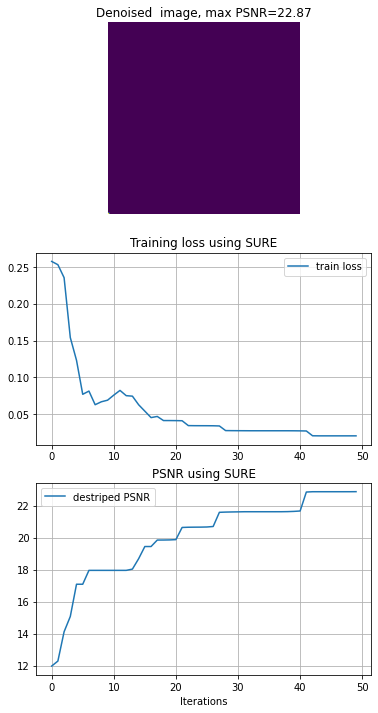

In [52]:
to_train = True
sure = True
num_epochs = 50
train_loss_results, destriped_psnr, destriped_ssim = train_model(
    to_train, filepath, ip_striped_data, ip_radiance_data, num_epochs
)
PUbestmodel, out_best = load_model_and_predict(filepath, ip_striped_data)

# show the output image
fig1, (ax, ax1, ax2) = plt.subplots(3, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(out_best[0][:, :, band], 0, 1))
ax.set_title("Denoised  image, max PSNR=" + str(np.round(np.max(destriped_psnr), 2)))
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.set_title("Training loss using SURE")
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(destriped_psnr, label="destriped PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR using SURE")
ax2.legend()
ax2.grid()

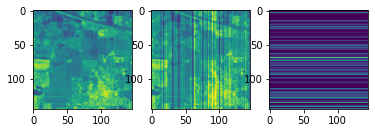

Band: 42
Original PSNR: 24.624303420128864
Destriped PSNR: 22.86944035883232


In [55]:
# show the output image
out_best = np.matmul(out_best, vh)
fig1, (ax, ax1, ax2, ax3) = plt.subplots(4, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(out_best[0][:, :, 133], 0, 1))
ax.set_title("Denoised  image, max PSNR=" + str(np.round(np.max(destriped_psnr), 2)))
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.set_title("Training loss using SURE")
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(destriped_psnr, label="destriped PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR using SURE")
ax2.legend()
ax2.grid()

# plot PSNR
ax3.plot(destriped_ssim, label="destriped SSIM")
ax3.set_xlabel("Iterations")
ax3.set_title("PSNR using SURE")
ax3.legend()
ax3.grid()

# show the images (clean, noisy, output from the trained model)
band = 42
plt.subplot(131)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(132)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()
print("Band: " + str(band))
print("Original PSNR: " + str(psnr(ip_radiance_data[0], ip_striped_data[0])))
print("Destriped PSNR: " + str(psnr(ip_radiance_data[0], out_best[0])))